## 自动求导例子

$y = 2\mathbf{x}^{\top}\mathbf{x}$关于列向量$\mathbf{x}$求导。

In [1]:
import torch

x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

In [2]:
x.requires_grad_(True) # x = torch.arange(0, 4, requires_grad=True)
x.grad # 默认为None

In [3]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

In [4]:
# 反向传播
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [5]:
# 梯度为4x
x.grad == 4 * x

tensor([True, True, True, True])

In [6]:
# 另一个例子
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## 非标量的反向传播
pytorch默认情况下是标量对向量的求导，对于非标量的反向传播，需要指定对那些变量进行求导，否则得到的是梯度的和。

In [7]:
x * x

tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)

In [8]:
x.grad.zero_()
y = x * x
y.backward(torch.tensor([1, 0, 0, 0]), retain_graph=True)
x0 = x.grad.clone()

# x.grad = torch.zeros_like(x.grad)
x.grad.zero_()
y.backward(torch.tensor([0, 1, 0, 0]), retain_graph=True)
x1 = x.grad.clone()

x.grad.zero_()
y.backward(torch.tensor([0, 0, 1, 0]), retain_graph=True)
x2 = x.grad.clone()

x.grad.zero_()
y.backward(torch.tensor([0, 0, 0, 1]), retain_graph=True)
# y.sum().backward(retain_graph=True)
x3 = x.grad.clone()

x.grad.zero_()
y.backward(torch.tensor([1, 1, 1, 1]))
x4 = x.grad.clone()

x0, x1, x2, x3, x4

(tensor([0., 0., 0., 0.]),
 tensor([0., 2., 0., 0.]),
 tensor([0., 0., 4., 0.]),
 tensor([0., 0., 0., 6.]),
 tensor([0., 2., 4., 6.]))

## 分离计算
有时候需要将某些计算移动到计算图外，例如$z = xy$, $y = x^2$，当我们想计算`z`对`x`的梯度，但是又想让`y`当作常量，这是我们可以分离`y`返回一个新变量`u`，`u`和`y`具有相同的值，但丢弃计算图关于`y`的计算，这样梯度就不会从`u`流向`y`。

In [9]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x
z.sum().backward()
x.grad == u

tensor([True, True, True, True])

根据`y`的计算结构，在`y`上调用反向传播，得到`y`对`x`的梯度。

In [10]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

## Python控制流的梯度计算
使用自动求导，即使构建函数的计算图需要通过 Python控制流（例如，条件、循环或任意函数调用），我们仍然可以计算得到的变量的梯度。

In [11]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [12]:
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

我们现在可以分析上面定义的 `f` 函数。请注意，它在其输入 `a` 中是分段线性的。换言之，对于任何 `a`，存在某个常量标量 `k`，使得 `f(a) = k * a`，其中 `k` 的值取决于输入 `a`。因此，`d / a` 允许我们验证梯度是否正确。

In [13]:
a.grad == d / a

tensor(True)

## 练习
1. 为什么计算二阶导数比一阶导数的开销要更大？
1. 在运行反向传播函数之后，立即再次运行它，看看会发生什么。
1. 在控制流的例子中，我们计算 `d` 关于 `a` 的导数，如果我们将变量 `a` 更改为随机向量或矩阵，会发生什么？此时，计算结果 `f(a)` 不再是标量。结果会发生什么？我们如何分析这个结果？
1. 重新设计一个求控制流梯度的例子。运行并分析结果。
1. 使$f(x) = \sin(x)$，绘制$f(x)$ 和$\frac{df(x)}{dx}$的图像，其中后者不使用$f'(x) = \cos(x)$。

In [14]:
import math
x = torch.arange(0, 2*math.pi, 0.1, requires_grad=True)
y = torch.sin(x)

In [15]:
y.sum().backward()
x.grad

tensor([ 1.0000,  0.9950,  0.9801,  0.9553,  0.9211,  0.8776,  0.8253,  0.7648,
         0.6967,  0.6216,  0.5403,  0.4536,  0.3624,  0.2675,  0.1700,  0.0707,
        -0.0292, -0.1288, -0.2272, -0.3233, -0.4161, -0.5048, -0.5885, -0.6663,
        -0.7374, -0.8011, -0.8569, -0.9041, -0.9422, -0.9710, -0.9900, -0.9991,
        -0.9983, -0.9875, -0.9668, -0.9365, -0.8968, -0.8481, -0.7910, -0.7259,
        -0.6536, -0.5748, -0.4903, -0.4008, -0.3073, -0.2108, -0.1122, -0.0124,
         0.0875,  0.1865,  0.2837,  0.3780,  0.4685,  0.5544,  0.6347,  0.7087,
         0.7756,  0.8347,  0.8855,  0.9275,  0.9602,  0.9833,  0.9965])

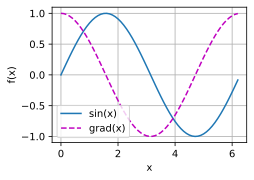

In [16]:
from d2l import torch as d2l
d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.detach().numpy()], 'x', 'f(x)', legend=['sin(x)', 'grad(x)'])

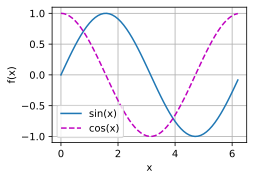

In [17]:
d2l.plot(x.detach().numpy(), [y.detach().numpy(), torch.cos(x).detach().numpy()], 'x', 'f(x)', legend=['sin(x)', 'cos(x)'])